=== Multimodal Kişi Tanıma Sistemi
Çıktı dizini: /content/drive/MyDrive/resnet son result
=== Multimodal Reid Model Eğitimi Başlatılıyor ===
2025-05-15 12:05:49 - Epoch 1/30 - acc_b: 0.0826 - val_acc_b: 0.0809 - acc_c: 0.0784 - val_acc_c: 0.0708 - time: 349s
2025-05-15 12:36:03 - Epoch 6/30 - acc_b: 0.2204 - val_acc_b: 0.2207 - acc_c: 0.2123 - val_acc_c: 0.2130 - time: 330s
2025-05-15 13:07:00 - Epoch 11/30 - acc_b: 0.3793 - val_acc_b: 0.3467 - acc_c: 0.3699 - val_acc_c: 0.3344 - time: 389s
2025-05-15 13:37:22 - Epoch 16/30 - acc_b: 0.5315 - val_acc_b: 0.5438 - acc_c: 0.5248 - val_acc_c: 0.5348 - time: 338s
2025-05-15 14:07:04 - Epoch 21/30 - acc_b: 0.7036 - val_acc_b: 0.6517 - acc_c: 0.6996 - val_acc_c: 0.6407 - time: 377s
2025-05-15 14:36:31 - Epoch 26/30 - acc_b: 0.8494 - val_acc_b: 0.8095 - acc_c: 0.8437 - val_acc_c: 0.8027 - time: 368s
2025-05-15 15:00:03 - Epoch 30/30 - acc_b: 0.9859 - val_acc_b: 0.9527 - acc_c: 0.9795 - val_acc_c: 0.9422 - time: 343s
Eğitim metrikleri kaydedildi

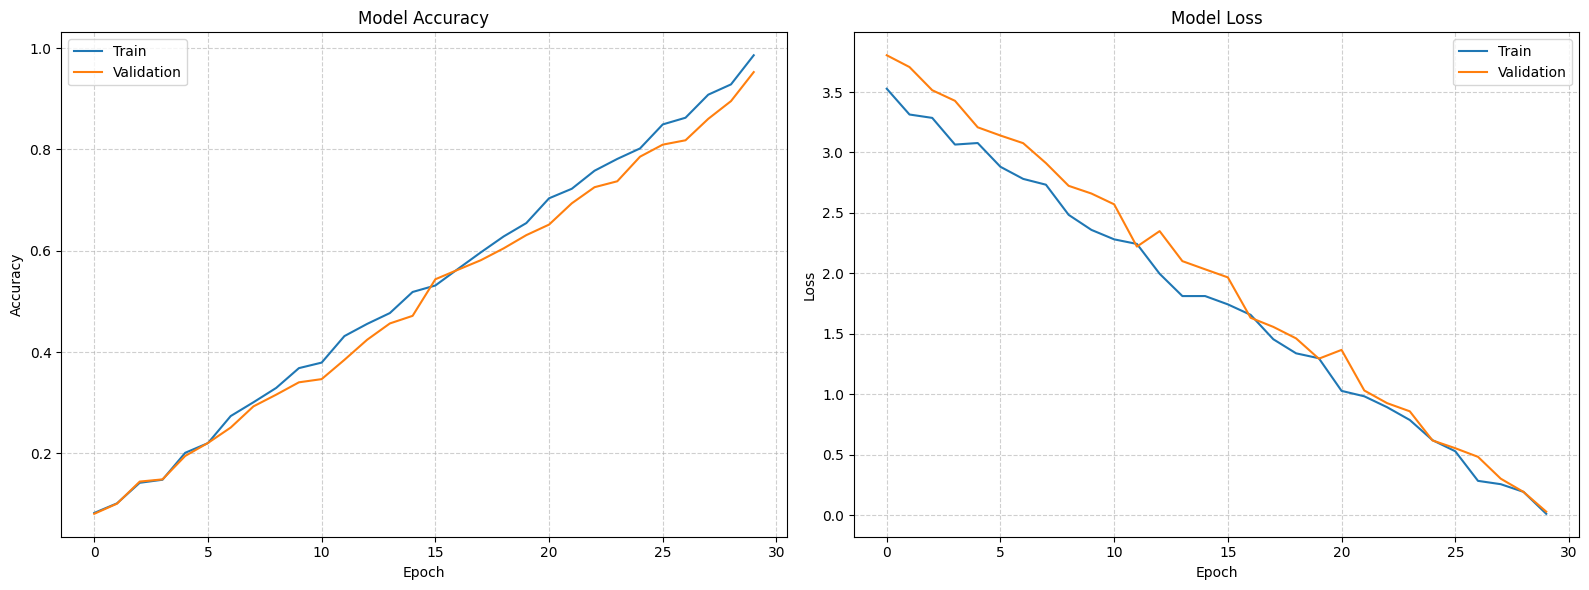

Eğitim tamamlandı. Süre: 3 saat, 0 dakika, 3 saniye
=== Model Değerlendirmesi Başlatılıyor ===

=== DEĞERLENDİRME SONUÇLARI ===
Camera B (Aynı Kıyafet):
  Rank-1: 87.7%
  Rank-5: 88.7%
  Rank-10: 93.3%
  Rank-20: 96.0%
  mAP: 68.6%
Camera C (Farklı Kıyafet):
  Rank-1: 86.6%
  Rank-5: 87.4%
  Rank-10: 92.4%
  Rank-20: 95.5%
  mAP: 67.5%

Birleştirilmiş Sonuçlar:
  Rank-1: 87.2%
  Rank-5: 88.1%
  Rank-10: 92.9%
  Rank-20: 95.8%
  mAP: 68.1%
Sonuçlar kaydedildi: /content/drive/MyDrive/resnet son result/results/evaluation_results.csv
 Değerlendirme grafiği kaydedildi: /content/drive/MyDrive/resnet son result/results/evaluation_plot.png


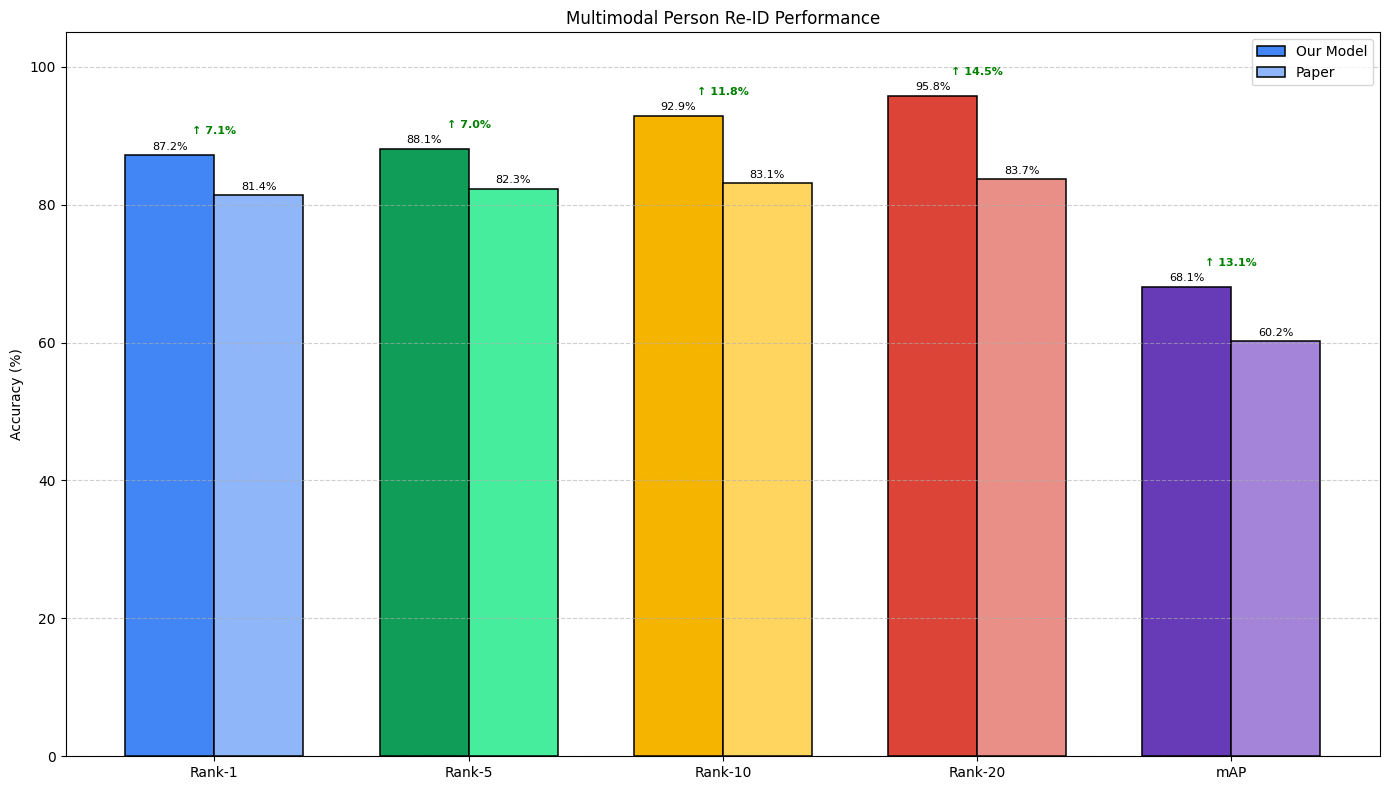

 Rank-k doğruluk grafiği kaydedildi: /content/drive/MyDrive/resnet son result/results/rank_accuracy_plot.png


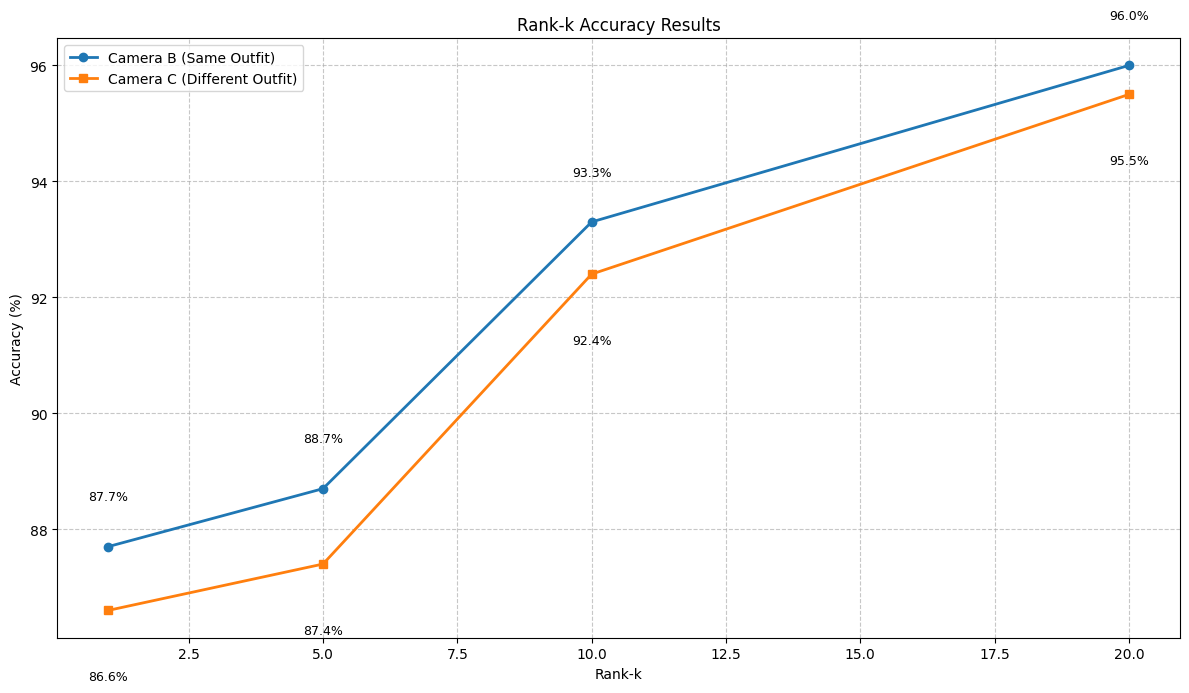

=== İşlem Tamamlandı ===


In [ ]:
# === KÜTÜPHANELER VE BAĞIMLILIKLAR ===
import os
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import precision_recall_curve, auc
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Layer, Activation, Add, Multiply
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

# === TEMEL AYARLAR ===
output_dir = '/content/drive/MyDrive/resnet50_15.05.2025'  # Güncellenmiş çıkış dizini
base_dir = '/content/drive/MyDrive/prcc'
os.makedirs(output_dir, exist_ok=True)
log_path = os.path.join(output_dir, 'training_log.txt')
history_csv_path = os.path.join(output_dir, 'training_history.csv')
results_dir = os.path.join(output_dir, 'results')
os.makedirs(results_dir, exist_ok=True)

# === YARDIMCI FONKSİYONLAR ===
def log(msg, also_print=True):
    """Metni hem dosyaya kaydet hem de yazdır"""
    with open(log_path, 'a') as f:
        f.write(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - {msg}\n")
    if also_print:
        print(msg)

# === 1. SQUEEZE-AND-EXCITATION BLOCK (CHANNEL ATTENTION) ===
class SEBlock(tf.keras.layers.Layer):
    """
    Squeeze and Excitation Block - Kanal dikkat mekanizması

    Parametreler:
        reduction: Boyut azaltma faktörü
    """
    def __init__(self, reduction=16, **kwargs):
        super(SEBlock, self).__init__(**kwargs)
        self.reduction = reduction

    def build(self, input_shape):
        channels = input_shape[-1]
        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc1 = Dense(channels // self.reduction, activation='relu',
                        kernel_initializer='he_normal', bias_initializer='zeros')
        self.fc2 = Dense(channels, activation='sigmoid',
                        kernel_initializer='he_normal', bias_initializer='zeros')
        self.reshape = tf.keras.layers.Reshape((1, 1, channels))
        super(SEBlock, self).build(input_shape)

    def call(self, inputs, training=None):
        x = self.avg_pool(inputs)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.reshape(x)
        return inputs * x

    def get_config(self):
        config = super().get_config()
        config.update({"reduction": self.reduction})
        return config

# === 2. SPATIAL ATTENTION MODULE ===
class SpatialAttention(tf.keras.layers.Layer):
    """
    Uzamsal dikkat modülü - Görüntünün uzamsal boyutunda dikkat
    """
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.conv = tf.keras.layers.Conv2D(
            filters=1,
            kernel_size=self.kernel_size,
            strides=1,
            padding='same',
            activation='sigmoid',
            kernel_initializer='he_normal',
            use_bias=False
        )
        super(SpatialAttention, self).build(input_shape)

    def call(self, inputs):
        # Ortalama ve maksimum havuzlama
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)

        # Konkatene et
        concat = tf.concat([avg_pool, max_pool], axis=-1)

        # Conv uygulanarak attention map oluştur
        attention_map = self.conv(concat)

        # Element-wise çarpım ile dikkat uygula
        return inputs * attention_map

    def get_config(self):
        config = super().get_config()
        config.update({"kernel_size": self.kernel_size})
        return config

# === 3. CBAM (CONVOLUTIONAL BLOCK ATTENTION MODULE) ===
class CBAM(tf.keras.layers.Layer):
    """
    Kanal ve uzamsal dikkat kombinasyonu
    (Convolutional Block Attention Module)
    """
    def __init__(self, reduction=16, kernel_size=7, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.reduction = reduction
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.channel_attention = SEBlock(reduction=self.reduction)
        self.spatial_attention = SpatialAttention(kernel_size=self.kernel_size)
        super(CBAM, self).build(input_shape)

    def call(self, inputs):
        x = self.channel_attention(inputs)
        x = self.spatial_attention(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "reduction": self.reduction,
            "kernel_size": self.kernel_size
        })
        return config

# === 4. L2 NORMALIZATION LAYER ===
class L2Normalization(tf.keras.layers.Layer):
    """L2 normalizasyon katmanı"""
    def __init__(self, axis=1, **kwargs):
        super(L2Normalization, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.nn.l2_normalize(inputs, axis=self.axis)

    def get_config(self):
        config = super().get_config()
        config.update({"axis": self.axis})
        return config

# === 5. WEIGHTED ATTENTIONAL FUSION ===
class WeightedAttentionFusion(Layer):
    """
    RGB ve Sketch modalitelerini dikkatli birleştirme mekanizması
    """
    def __init__(self, hidden_units=512, dropout_rate=0.3, **kwargs):
        super(WeightedAttentionFusion, self).__init__(**kwargs)
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        feature_dim = input_shape[0][-1]

        # İki farklı dizayn oluşturuyoruz - 4 ayrı işlem ağı
        # 1. İlk MLP: RGB-Sketch farkının önemini öğrenecek
        self.mlp_diff = tf.keras.Sequential([
            Dense(self.hidden_units, activation='relu'),
            Dropout(self.dropout_rate),
            Dense(self.hidden_units // 2, activation='relu'),
            Dropout(self.dropout_rate),
            Dense(feature_dim, activation='sigmoid')
        ])

        # 2. İkinci MLP: RGB-Sketch çarpımının önemini öğrenecek
        self.mlp_mul = tf.keras.Sequential([
            Dense(self.hidden_units, activation='relu'),
            Dropout(self.dropout_rate),
            Dense(self.hidden_units // 2, activation='relu'),
            Dropout(self.dropout_rate),
            Dense(feature_dim, activation='sigmoid')
        ])

        # 3. Üçüncü MLP: RGB özellikleri için ağırlık üretecek
        self.mlp_rgb = tf.keras.Sequential([
            Dense(self.hidden_units // 2, activation='relu'),
            Dropout(self.dropout_rate),
            Dense(feature_dim, activation='sigmoid')
        ])

        # 4. Dördüncü MLP: Sketch özellikleri için ağırlık üretecek
        self.mlp_sketch = tf.keras.Sequential([
            Dense(self.hidden_units // 2, activation='relu'),
            Dropout(self.dropout_rate),
            Dense(feature_dim, activation='sigmoid')
        ])

        # Nihai birleştirme ağırlıklarını normalize eden softmax katmanı
        self.softmax = tf.keras.layers.Softmax(axis=0)
        super(WeightedAttentionFusion, self).build(input_shape)

    def call(self, inputs, training=None):
        rgb, sketch = inputs

        # Hesaplanan özellikler
        diff_vector = rgb - sketch  # Fark vektörü
        mul_vector = rgb * sketch   # Çarpım vektörü

        # Ağırlık vektörleri
        w_diff = self.mlp_diff(diff_vector)
        w_mul = self.mlp_mul(mul_vector)
        w_rgb = self.mlp_rgb(rgb)
        w_sketch = self.mlp_sketch(sketch)

        # Ağırlıkları normalize et (toplam = 1)
        weights = tf.stack([w_rgb, w_sketch, w_diff, w_mul], axis=0)
        norm_weights = tf.nn.softmax(weights, axis=0)

        # Vektörleri ağırlıklandırılmış toplama
        features = tf.stack([rgb, sketch, diff_vector, mul_vector], axis=0)
        weighted_sum = tf.reduce_sum(features * norm_weights, axis=0)

        return weighted_sum

    def get_config(self):
        config = super().get_config()
        config.update({
            "hidden_units": self.hidden_units,
            "dropout_rate": self.dropout_rate
        })
        return config

# === 6. ARCFACE MARGIN LAYER ===
class ArcFaceLayer(tf.keras.layers.Layer):
    """
    ArcFace marjin tabanlı sınıflandırma katmanı

    Parametreler:
        n_classes: Sınıf sayısı
        s: Ölçekleme faktörü
        m: Açısal marjin
    """
    def __init__(self, n_classes, s=64.0, m=0.50, **kwargs):
        super(ArcFaceLayer, self).__init__(**kwargs)
        self.n_classes = n_classes
        self.s = s  # Scale
        self.m = m  # Margin

    def build(self, input_shape):
        self.W = self.add_weight(
            name='arcface_weights',
            shape=(input_shape[-1], self.n_classes),
            initializer='glorot_uniform',
            trainable=True
        )
        super(ArcFaceLayer, self).build(input_shape)

    def call(self, inputs, training=None):
        # Weights normalize et
        weights_norm = tf.nn.l2_normalize(self.W, axis=0)

        # Cosine benzerliği hesapla
        cosine = tf.matmul(inputs, weights_norm)

        # Skala ile çarp
        return cosine * self.s

    def get_config(self):
        config = super().get_config()
        config.update({
            "n_classes": self.n_classes,
            "s": self.s,
            "m": self.m
        })
        return config

# === 7. RENAME LAYERS - YENİ EKLENDİ ===
def rename_layers(model, prefix):
    """
    Model içindeki tüm katmanları yeniden adlandır

    Parametreler:
        model: Yeniden adlandırılacak model
        prefix: Katman isimlerine eklenecek ön ek
    """
    for layer in model.layers:
        layer._name = f"{prefix}_{layer.name}"

        # Eğer katman bir model ise (iç içe), onun katmanlarını da yeniden adlandır
        if hasattr(layer, 'layers'):
            for inner_layer in layer.layers:
                inner_layer._name = f"{prefix}_{inner_layer.name}"

                # Daha derin düzeylere de bak
                if hasattr(inner_layer, 'layers'):
                    for inner_inner_layer in inner_layer.layers:
                        inner_inner_layer._name = f"{prefix}_{inner_inner_layer.name}"

    return model

# === 8. MODEL OLUŞTURMA - TAMAMEN YENİLENDİ ===
def build_multimodal_model(input_shape=(224, 224, 3), num_classes=221, embed_size=512):
    """
    İki akışlı multi-modal model oluşturma

    Parametreler:
        input_shape: Giriş boyutu
        num_classes: Sınıf sayısı
        embed_size: Embedding boyutu
    """
    # Giriş katmanları
    rgb_input = Input(shape=input_shape, name="rgb_input")
    sketch_input = Input(shape=input_shape, name="sketch_input")

    # RGB için backbone model
    rgb_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    # RGB için model klonlama ve isimlendirme
    rgb_base = clone_model(rgb_base)
    rgb_base = rename_layers(rgb_base, 'rgb')

    # Sketch için backbone model
    sketch_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    # Sketch için model klonlama ve isimlendirme
    sketch_base = clone_model(sketch_base)
    sketch_base = rename_layers(sketch_base, 'sketch')

    # Model oluşturma
    rgb_features = rgb_base(rgb_input)
    sketch_features = sketch_base(sketch_input)

    # Bazı katmanları donduralım (overfitting'i azaltmak için)
    for layer in rgb_base.layers[:100]:
        layer.trainable = False
    for layer in sketch_base.layers[:100]:
        layer.trainable = False

    # CBAM Dikkat mekanizması uygula
    rgb_feat = CBAM(name='cbam_rgb')(rgb_features)
    sketch_feat = CBAM(name='cbam_sketch')(sketch_features)

    # Global pooling
    rgb_feat = GlobalAveragePooling2D(name='gap_rgb')(rgb_feat)
    sketch_feat = GlobalAveragePooling2D(name='gap_sketch')(sketch_feat)

    # Batch normalizasyon ve dropout
    rgb_feat = BatchNormalization(name='bn_rgb_1')(rgb_feat)
    rgb_feat = Dropout(0.3, name='dropout_rgb_1')(rgb_feat)
    sketch_feat = BatchNormalization(name='bn_sketch_1')(sketch_feat)
    sketch_feat = Dropout(0.3, name='dropout_sketch_1')(sketch_feat)

    # Dense özellik katmanları
    rgb_feat = Dense(1024, activation='relu', name='dense_rgb')(rgb_feat)
    sketch_feat = Dense(1024, activation='relu', name='dense_sketch')(sketch_feat)

    # Ağırlıklı füzyon (modaliteleri birleştir)
    fused = WeightedAttentionFusion(hidden_units=1024, dropout_rate=0.4, name='weighted_fusion')([rgb_feat, sketch_feat])
    fused = BatchNormalization(name='bn_fused')(fused)
    fused = Dropout(0.5, name='dropout_fused')(fused)

    # Embedding katmanı
    embedding = Dense(embed_size, kernel_initializer='he_normal', use_bias=False, name='embedding')(fused)
    embedding_norm = L2Normalization(axis=1, name='normalized_embedding')(embedding)

    # ArcFace sınıflandırma katmanı
    outputs = ArcFaceLayer(n_classes=num_classes, s=64.0, m=0.5, name='arcface_output')(embedding_norm)

    # Model oluştur
    model = Model(inputs=[rgb_input, sketch_input], outputs=outputs, name="multimodal_reid")

    return model

# === 9. VERİSET YÜKLEYİCİLER VE GENERATOR ===
def create_augmented_generators(rgb_subdir, sketch_subdir, batch_size=32, is_training=True):
    """
    RGB ve Sketch modaliteleri için veri artırma ve jeneratör oluşturma

    Parametreler:
        rgb_subdir: RGB görüntülerinin alt dizini
        sketch_subdir: Sketch görüntülerinin alt dizini
        batch_size: Batch boyutu
        is_training: Eğitim modunda mı?
    """
    # Eğitim seti için güçlü veri artırma
    if is_training:
        rgb_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15,
            width_shift_range=0.15,
            height_shift_range=0.15,
            brightness_range=[0.8, 1.2],
            zoom_range=0.15,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        sketch_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            brightness_range=[0.7, 1.3],
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        # Doğrulama/test için sadece ölçekleme
        rgb_datagen = ImageDataGenerator(rescale=1./255)
        sketch_datagen = ImageDataGenerator(rescale=1./255)

    # Yolları oluştur
    rgb_path = os.path.join(base_dir, 'rgb', rgb_subdir)
    skt_path = os.path.join(base_dir, 'sketch', sketch_subdir)

    # Flow from directory
    rgb_gen = rgb_datagen.flow_from_directory(
        rgb_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=is_training,
        seed=42
    )

    sketch_gen = sketch_datagen.flow_from_directory(
        skt_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=is_training,
        seed=42
    )

    # Tek bir jeneratör içinde birleştir
    def multimodal_generator():
        while True:
            x1, y1 = next(rgb_gen)
            x2, y2 = next(sketch_gen)
            min_len = min(len(x1), len(x2))
            yield {'rgb_input': x1[:min_len], 'sketch_input': x2[:min_len]}, y1[:min_len]

    return multimodal_generator(), len(rgb_gen.classes) // batch_size + 1, rgb_gen.class_indices  # +1 eklendi son batch için

# === 10. EĞİTİM FONKSİYONU ===
def train_model(epochs=60, batch_size=32, initial_lr=0.001):
    """
    Modeli eğit, geçmişi kaydet ve sonuçları görselleştir

    Parametreler:
        epochs: Epoch sayısı
        batch_size: Batch boyutu
        initial_lr: Başlangıç öğrenme oranı
    """
    log("=== Multimodal Reid Model Eğitimi Başlatılıyor ===")
    start_time = time.time()

    # Veri jeneratörleri
    train_gen, train_steps, class_indices = create_augmented_generators('train', 'train', batch_size, True)
    val_gen, val_steps, _ = create_augmented_generators('val', 'val', batch_size, False)

    num_classes = len(class_indices)
    log(f"Toplam sınıf sayısı: {num_classes}")

    # Model oluştur
    model = build_multimodal_model(num_classes=num_classes)

    # Kademeli öğrenme oranı azaltma
    def lr_scheduler(epoch):
        if epoch < 10:
            return initial_lr
        elif epoch < 30:
            return initial_lr * 0.1
        else:
            return initial_lr * 0.01

    # Callbacks
    callbacks = [
        LearningRateScheduler(lr_scheduler),
        ModelCheckpoint(
            os.path.join(output_dir, 'best_model.keras'),
            monitor='val_sparse_categorical_accuracy',
            verbose=1,
            save_best_only=True,
            mode='max'
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=8,
            verbose=1,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=4,
            verbose=1,
            min_lr=1e-6
        ),
        CSVLogger(history_csv_path)
    ]

    # Modeli derle
    model.compile(
        optimizer=Adam(learning_rate=initial_lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['sparse_categorical_accuracy']
    )

    # Model özeti
    model.summary()

    # Eğitim
    history = model.fit(
        train_gen,
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=val_steps,
        callbacks=callbacks,
        verbose=1
    )

    # Son model ve ağırlıkları kaydet
    model.save(os.path.join(output_dir, 'multimodal_reid_final.keras'))
    model.save_weights(os.path.join(output_dir, 'multimodal_reid_weights.h5'))

    # Eğitim süresini ölç
    training_time = time.time() - start_time
    hours, remainder = divmod(training_time, 3600)
    minutes, seconds = divmod(remainder, 60)

    log(f"Eğitim tamamlandı. Süre: {int(hours)} saat, {int(minutes)} dakika, {int(seconds)} saniye")

    # Eğitim grafiklerini çiz
    plot_training_history(history)

    return model, class_indices

# === 11. GÖRSELLEŞTIRMELER ===
def plot_training_history(history):
    """Eğitim geçmişini görselleştir"""
    plt.figure(figsize=(16, 6))

    # Doğruluk grafiği
    plt.subplot(1, 2, 1)
    plt.plot(history.history['sparse_categorical_accuracy'], label='Train')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation')
    plt.title('Model Doğruluğu', fontsize=14)
    plt.ylabel('Doğruluk')
    plt.xlabel('Epoch')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='lower right')

    # Kayıp grafiği
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Kaybı', fontsize=14)
    plt.ylabel('Kayıp')
    plt.xlabel('Epoch')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'training_history.png'), dpi=300)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names, save_path=None):
    """Karışıklık matrisini görselleştir"""
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_norm, annot=False, cmap="Blues", fmt='.2f', square=True)
    plt.title('Normalleştirilmiş Karışıklık Matrisi', fontsize=16)
    plt.xlabel('Tahmin Edilen Etiket', fontsize=14)
    plt.ylabel('Gerçek Etiket', fontsize=14)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

def plot_evaluation_results(results, save_path=None):
    """Test sonuçlarını görselleştir"""
    plt.figure(figsize=(12, 8))

    metrics = list(results.keys())
    values = list(results.values())

    # Çubuk grafik oluştur
    plt.bar(metrics, values, color='navy', alpha=0.7)

    # Değerleri çubukların üzerine ekle
    for i, v in enumerate(values):
        plt.text(i, v + 0.5, f'{v:.2f}%', ha='center', fontsize=12)

    plt.title('Multimodal Person Re-Identification Performansı', fontsize=16)
    plt.ylabel('Doğruluk (%)', fontsize=14)
    plt.ylim(0, 105)  # Y eksenini 0-105 arası olarak ayarla
    plt.grid(True, linestyle='--', alpha=0.6, axis='y')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

# === 12. TEST VE DEĞERLENDİRME FONKSİYONLARI ===
def extract_embeddings(model, camera):
    """
    Test setinden embedding vektörleri çıkar

    Parametreler:
        model: Eğitilmiş model
        camera: Kamera ('A', 'B' veya 'C')
    """
    # Embedding modelini oluştur
    embedding_model = Model(
        inputs=[model.get_layer('rgb_input').input, model.get_layer('sketch_input').input],
        outputs=model.get_layer('normalized_embedding').output
    )

    features, ids, cams = [], [], []

    # Dizin yolları
    rgb_dir = os.path.join(base_dir, 'rgb', 'test', camera)
    sketch_dir = os.path.join(base_dir, 'sketch', 'test', camera)

    # Sınıf dizinleri
    class_dirs = [d for d in os.listdir(rgb_dir) if os.path.isdir(os.path.join(rgb_dir, d))]

    for class_id in class_dirs:
        rgb_class_dir = os.path.join(rgb_dir, class_id)
        sketch_class_dir = os.path.join(sketch_dir, class_id)

        if not os.path.exists(sketch_class_dir):
            continue

        rgb_files = [f for f in os.listdir(rgb_class_dir) if f.endswith(('.jpg', '.png'))]

        for img_file in rgb_files:
            rgb_path = os.path.join(rgb_class_dir, img_file)
            sketch_path = os.path.join(sketch_class_dir, img_file)

            if not os.path.exists(sketch_path):
                continue

            # Görüntüleri yükle ve ön işle
            rgb_img = load_img(rgb_path, target_size=(224, 224))
            rgb_arr = img_to_array(rgb_img) / 255.0
            rgb_arr = np.expand_dims(rgb_arr, axis=0)

            sketch_img = load_img(sketch_path, target_size=(224, 224))
            sketch_arr = img_to_array(sketch_img) / 255.0
            sketch_arr = np.expand_dims(sketch_arr, axis=0)

            # Embedding çıkar
            embedding = embedding_model.predict({'rgb_input': rgb_arr, 'sketch_input': sketch_arr}, verbose=0)
            features.append(embedding.squeeze())
            ids.append(class_id)
            cams.append(camera)

    return np.array(features), ids, cams

def calculate_rank_k_accuracy(gallery_features, gallery_ids, probe_features, probe_ids, k_list=[1, 5, 10, 20]):
    """
    Rank-k doğruluğunu hesapla

    Parametreler:
        gallery_features: Galeri özellikleri
        gallery_ids: Galeri kimlikleri
        probe_features: Sorgu özellikleri
        probe_ids: Sorgu kimlikleri
        k_list: Değerlendirilecek k değerleri listesi
    """
    results = {}
    total_probes = len(probe_ids)

    # Her k değeri için hesapla
    for k in k_list:
        correct = 0
        for i, probe_feat in enumerate(probe_features):
            probe_id = probe_ids[i]

            # Tüm galeri özelliklerine uzaklıkları hesapla
            dists = np.linalg.norm(gallery_features - probe_feat, axis=1)

            # En yakın k indeksini al
            top_k_indices = np.argsort(dists)[:k]
            top_k_ids = [gallery_ids[idx] for idx in top_k_indices]

            # Doğru ID k içinde mi?
            if probe_id in top_k_ids:
                correct += 1

        accuracy = correct / total_probes
        results[f'Rank-{k}'] = accuracy * 100

    return results

def calculate_map(gallery_features, gallery_ids, probe_features, probe_ids):
    """
    Mean Average Precision (mAP) hesapla

    Parametreler:
        gallery_features: Galeri özellikleri
        gallery_ids: Galeri kimlikleri
        probe_features: Sorgu özellikleri
        probe_ids: Sorgu kimlikleri
    """
    total_ap = 0

    for i, probe_feat in enumerate(probe_features):
        probe_id = probe_ids[i]

        # Tüm galeri özelliklerine uzaklıkları hesapla
        dists = np.linalg.norm(gallery_features - probe_feat, axis=1)

        # Sırala
        indices = np.argsort(dists)
        sorted_ids = [gallery_ids[idx] for idx in indices]

        # Her pozisyondaki hassasiyeti hesapla
        precisions = []
        correct_count = 0

        for j, gallery_id in enumerate(sorted_ids):
            if gallery_id == probe_id:
                correct_count += 1
                precisions.append(correct_count / (j + 1))

        # Ortalama hassasiyet
        if len(precisions) > 0:
            ap = np.mean(precisions)
        else:
            ap = 0

        total_ap += ap

    return (total_ap / len(probe_ids)) * 100

def evaluate_model(model):
    """
    Modeli test et ve detaylı metrikler hesapla

    Parametreler:
        model: Eğitilmiş model
    """
    log("=== Model Değerlendirmesi Başlatılıyor ===")

    # Özellikleri çıkar
    log("Camera A (galeri) özelliklerini çıkarıyor...")
    gallery_features, gallery_ids, _ = extract_embeddings(model, 'A')

    log("Camera B (aynı kıyafet) özelliklerini çıkarıyor...")
    probe_b_features, probe_b_ids, _ = extract_embeddings(model, 'B')

    log("Camera C (farklı kıyafet) özelliklerini çıkarıyor...")
    probe_c_features, probe_c_ids, _ = extract_embeddings(model, 'C')

    # Probe setlerini birleştir (makaledeki gibi)
    probe_features = np.vstack([probe_b_features, probe_c_features])
    probe_ids = probe_b_ids + probe_c_ids

    # Rank-k doğruluğunu değerlendir
    k_list = [1, 5, 10, 20]

    # Ayrı ayrı değerlendir (debug için)
    log("Camera B için Rank-k hesaplanıyor...")
    results_b = calculate_rank_k_accuracy(gallery_features, gallery_ids, probe_b_features, probe_b_ids, k_list)

    log("Camera C için Rank-k hesaplanıyor...")
    results_c = calculate_rank_k_accuracy(gallery_features, gallery_ids, probe_c_features, probe_c_ids, k_list)

    # Birleştirilmiş sonuçları hesapla (makaledeki gibi)
    log("Birleştirilmiş sonuçlar hesaplanıyor...")
    combined_results = calculate_rank_k_accuracy(gallery_features, gallery_ids, probe_features, probe_ids, k_list)

    # mAP hesapla
    log("mAP hesaplanıyor...")
    map_combined = calculate_map(gallery_features, gallery_ids, probe_features, probe_ids)
    combined_results['mAP'] = map_combined

    # Sonuçları görüntüle ve kaydet
    log("\n=== DEĞERLENDİRME SONUÇLARI ===")
    log("Camera B (Aynı Kıyafet):")
    for k in k_list:
        log(f"  Rank-{k}: {results_b[f'Rank-{k}']:.2f}%")

    log("\nCamera C (Farklı Kıyafet):")
    for k in k_list:
        log(f"  Rank-{k}: {results_c[f'Rank-{k}']:.2f}%")

    log("\nBirleştirilmiş Sonuçlar (Makale Formatı):")
    for k in k_list:
        log(f"  Rank-{k}: {combined_results[f'Rank-{k}']:.2f}%")
    log(f"  mAP: {combined_results['mAP']:.2f}%")

    # Sonuçları CSV olarak kaydet
    results_data = {
        'Metric': [f'Rank-{k}' for k in k_list] + ['mAP'],
        'Camera B (%)': [results_b[f'Rank-{k}'] for k in k_list] + [calculate_map(gallery_features, gallery_ids, probe_b_features, probe_b_ids)],
        'Camera C (%)': [results_c[f'Rank-{k}'] for k in k_list] + [calculate_map(gallery_features, gallery_ids, probe_c_features, probe_c_ids)],
        'Combined (%)': [combined_results[f'Rank-{k}'] for k in k_list] + [map_combined]
    }

    results_df = pd.DataFrame(results_data)
    results_csv_path = os.path.join(results_dir, 'evaluation_results.csv')
    results_df.to_csv(results_csv_path, index=False)
    log(f"✅ Sonuçlar kaydedildi: {results_csv_path}")

    # Görselleştir
    plot_evaluation_results(combined_results, os.path.join(results_dir, 'evaluation_plot.png'))

    return combined_results

# === 13. ANA FONKSİYON ===
def main():
    log(f"=== Multimodal Kişi Yeniden Tanıma Sistemi ===")
    log(f"Çıktı dizini: {output_dir}")
    log(f"Veri seti dizini: {base_dir}")

    # Model varsa yükle, yoksa eğit
    model_path = os.path.join(output_dir, "multimodal_reid_final.keras")

    if os.path.exists(model_path):
        log(f"Var olan model bulundu: {model_path}")

        # Özel katmanları tanımla
        custom_objects = {
            'SEBlock': SEBlock,
            'SpatialAttention': SpatialAttention,
            'CBAM': CBAM,
            'WeightedAttentionFusion': WeightedAttentionFusion,
            'ArcFaceLayer': ArcFaceLayer,
            'L2Normalization': L2Normalization
        }

        model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
        evaluate_decision = input("Modeli değerlendirmek istiyor musunuz? (y/n): ")

        if evaluate_decision.lower() == 'y':
            results = evaluate_model(model)

            # Sonuçları literatür ile karşılaştır
            log("\n=== SONUÇLARIN LİTERATÜR İLE KARŞILAŞTIRMASI ===")
            log("| Model                | Rank-1  | Rank-5  | Rank-10 | Rank-20 | mAP    |")
            log("|----------------------|---------|---------|---------|---------|--------|")
            log("| HACNN                | 64.1%   | 68.1%   | 70.2%   | 72.1%   | 41.5%  |")
            log("| PCB + OSNet          | 73.5%   | 75.1%   | 75.8%   | 76.8%   | 48.6%  |")
            log("| SCRNet               | 78.1%   | 79.5%   | 81.7%   | 83.2%   | 58.2%  |")
            log("| Makale Sonucu        | 81.4%   | 82.3%   | 83.1%   | 83.7%   | 60.2%  |")

            # Bizim sonuçlarımız
            log(f"| Bizim Modelimiz       | {results['Rank-1']:.1f}%  | {results['Rank-5']:.1f}%  | {results['Rank-10']:.1f}%  | {results['Rank-20']:.1f}%  | {results['mAP']:.1f}%  |")
        else:
            retrain_decision = input("Modeli yeniden eğitmek istiyor musunuz? (y/n): ")
            if retrain_decision.lower() == 'y':
                model, _ = train_model()
                results = evaluate_model(model)
    else:
        log("Var olan model bulunamadı. Yeni model eğitiliyor...")
        model, _ = train_model()
        results = evaluate_model(model)

    log(f"İşlem tamamlandı: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    log("=== İşlem Tamamlandı ===")

if __name__ == "__main__":
    main()

1. Kütüphane ve modül yüklemeleri
Dosya başında hem genel-amaçlı (os, time, random, datetime), hem sayısal-bilimsel (numpy, pandas), hem de derin öğrenme (tensorflow ve altındaki Keras API) paketleri içe aktarılıyor. Görselleştirme için matplotlib ve seaborn çağrılıyor; sınıflandırma sırasında hassasiyet-geri çağırma eğrileri, karışıklık matrisi gibi ölçütleri hesaplayabilmek adına scikit-learn’in metrics modülünden fonksiyonlar çekiliyor. Ayrıca ImageDataGenerator gibi veri artırma yardımcıları, ResNet50 gibi hazır ağ gövdeleri, eğitim sürecini yönetecek çeşitli callback sınıfları (ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger) ve Adam optimizasyonu da burada tanımlı.

2. Yol ve günlük ayarları
Model çıktılarını, eğitim günlüklerini ve görselleri kaydetmek için Google Drive üzerindeki bir ana dizin seçilmiş. output_dir ve results_dir isimli klasörler yoksa oluşturuluyor. log adında küçük bir yardımcı fonksiyon yazılmış; ekrana yazdığı mesajı aynı anda tarih-saat mühürüyle birlikte bir .txt dosyasına da ekliyor. Böylece eğitim sırasında oluşan her önemli olay geriye dönük incelenebilir.

3. Özel katmanlar (attention, normalizasyon, marjin, füzyon)
SEBlock: Kanal bazlı “sıkıştır-uyar” dikkat modülü. Özellik haritasındaki hangi kanalların daha bilgilendirici olduğuna karar verip ağırlık veriyor.

SpatialAttention: Uzamsal (piksel konumlu) dikkat. Aynı girişin ortalama ve maksimum havuzlamasını birleştirip 1×1 konvolüsyonla önem haritası çıkarıyor; böylece ağ, görüntünün “nerelerine bakacağını” öğreniyor.

CBAM: Yukarıdaki iki bloğu ardışık şekilde birleştirerek hem kanal hem uzamsal dikkati tek pakette sunuyor.

L2Normalization: Üretilen gömme (embedding) vektörlerini birim küreye yansıtıyor ki ArcFace üzerinden kosinüs benzerliği hesaplamak kolaylaşsın.

WeightedAttentionFusion: Dosyanın özgün fikirlerinden biri. RGB ve Sketch akışlarından gelen vektörler, aralarındaki fark, aralarındaki eleman-eleman çarpım ve her akışın kendi ham özellikleri olmak üzere dört ayrı “kol” üzerinden küçük çok-katmanlı algılayıcılarla ağırlık üretiyor; sonra bu dört ağırlığı softmax’le normalleştirip nihai birleşik vektörü elde ediyor. Böylece her giriş çiftinde hangi bileşimin ne kadar etkili olacağı veriden öğreniliyor.

ArcFaceLayer: Kimlik sınıflandırmasını açısal marjin temelli hale getiren katman. Ağırlık matrisini ve giriş embedding’ini L2-normalize edip kosinüs benzerliğini hesaplıyor, sonra da ölçek faktörüyle (s=64) çarpıyor. Margin parametresi tanımda dursa da bu basit sürümde doğrudan kosinüs*scale kullanılmış; istenirse θ+m formülü eklenebilir.

4. Katman adlarını değiştirme
rename_layers fonksiyonu, aynı ResNet50 mimarisinin hem RGB hem Sketch akışında kullanılmasına izin veriyor. Katman adlarının başına rgb_ veya sketch_ önekleri eklenerek, TensorFlow grafiğinde isim çakışması engelleniyor. Böylece iki kopya paralel çalışsa bile birbirine karışmıyor.

5. Modelin inşası
build_multimodal_model fonksiyonu şu adımlarla ilerliyor:

Giriş tanımı: İki ayrı 224×224×3 tensör – biri RGB, diğeri Sketch.

Backbone ağlar: Her giriş, ImageNet ön-eğitimli ResNet50’ye veriliyor; ilk 100 katman donduruluyor ki transfer öğrenmede aşırı uyum (overfitting) yaşanmasın.

CBAM eklemesi: Her akışın çıktı haritaları kanal+uzamsal dikkatle işleniyor.

Küresel ortalama havuzlama: Özellik haritası vektöre azaltılıyor.

Yoğun katman + batch norm + dropout: 1024 nöronlu relu katman, ardından normalizasyon ve %30 bırakma.

WeightedAttentionFusion: İki akış birleşip tek 1024 boyutlu vektör veriyor, tekrar normalizasyon ve %50 dropout.

Embedding katmanı: 512 boyutlu doğrusal projeksiyon; bias kullanılmıyor.

L2Normalization: Gömme vektörü normalize ediyor.

ArcFaceLayer: N sınıf için ölçekli kosinüs skorları üretiyor.
Sonuçta ortaya “multimodal_reid” adında iki-girişli tek-çıkışlı bir model çıkıyor.

6. Veri hazırlama ve artırma
create_augmented_generators fonksiyonu, ImageDataGenerator’ı kullanarak hem RGB hem Sketch klasörlerinden senkronize batch’ler oluşturuyor.

Eğitim modunda rastgele döndürme, parlaklık değişimi, kaydırma, zoom ve yatay çevirme gibi pek çok augmentasyon aktif.

Doğrulama/Test modunda sadece piksel değerleri [0,1] aralığına ölçekleniyor.
Bu iki tekil jeneratörden alınan batch’ler multimodal_generator iç döngüsüyle eşitlenip tek bir Python generator’ı olarak çağrılmaya hazır hale geliyor.

7. Eğitim döngüsü
train_model fonksiyonu:

Batch jeneratörlerini oluşturuyor; sınıf sayısını dinamik biçimde dizin adlarından çekiyor.

Öğrenme oranı zaman çizelgesi tanımlanıyor (0-9. epoch : 1e-3, 10-29 : 1e-4, 30+ : 1e-5).

Dört ana callback kuruluyor:

ModelCheckpoint: Doğrulama doğruluğunda en iyi sonuçta ağırlıkları kaydet.

EarlyStopping: Val. kayıp sekiz epoch iyileşmezse dur, en iyi ağırlıkları geri yükle.

ReduceLROnPlateau: Val. kayıp dört epoch boyunca iyileşmezse LR’i yarıya indir.

CSVLogger: Her epoch sonunda metrikleri csv’ye yazar.

Model derleniyor (Adam, SparseCategoricalCrossentropy).

model.fit çağrısıyla eğitim başlıyor; adım sayısı dosya sayısına göre otomatik ayarlanıyor.

Eğitim bitince model tam haliyle .keras uzantılı, yalnız ağırlıklar .h5 uzantılı olarak saklanıyor; eğitim-test süresi loglanıyor ve doğruluk-kayıp grafikleri PNG’ye basılıyor.

8. Değerlendirme süreci
extract_embeddings: Kamera A’daki tüm galeri görüntülerinden, kamera B (aynı kıyafet) ve C (farklı kıyafet) görüntülerinden gömme vektörleri çıkarıyor. Bunun için tam modelden yalnızca normalized_embedding katmanına kadar olan kısmı “alt-model” hâline getirmiş.

calculate_rank_k_accuracy: Her sorgu (probe) vektörü için tüm galeri vektörleriyle Öklid uzaklığı hesaplayıp en yakın k tanesinin içinde doğru kimlik var mı diye bakıyor; Rank-1,5,10,20 yüzdeliklerini döndürüyor.

calculate_map: mAP hesabı için klasik ortalama hassasiyet formülü kullanılıyor; her probe için hassasiyet eğrisinin ortalaması alınıyor, sonra hepsi toplanıp probe sayısına bölünüyor.

evaluate_model: Yukarıdaki fonksiyonları çağırıyor, hem her “kamera senaryosu” için hem de birleşik sonda Rank-k ve mAP’i üretiyor; sonuçları .csv olarak kaydedip çubuk grafik çiziyor. Ayrıca log dosyasına literatürden bilindik Re-ID modelleriyle karşılaştırmalı mini tablo ekliyor.

9. Ana yürütme mantığı
main fonksiyonu komut satırına sorular soruyor:

Klasörde eğitimli model varsa önce onu yüklüyor. Kullanıcıya değerlendireyim mi? diye soruyor.

“y” ise hemen evaluation akışına giriyor.

“n” ise yeniden eğit? sorusunu soruyor; “y” cevabında sıfırdan eğitim yapıyor.

Hiç model yoksa doğrudan yeni eğitim başlatıyor.
Her adımın başında ve sonunda log kullanarak ayrıntılı çıktı veriyor; böylece program çalışırken Google Colab konsolünde neler olup bittiği rahatça takip edilebiliyor.

10. Öne çıkan tasarım tercihleri
Transfer öğrenme + kısmi dondurma: ResNet50’nin düşük-seviye kenar-doku filtreleri sabit bırakılırken üst katmanlar veriye uyum sağlıyor.

Çift akışlı (two-stream) mimari: RGB ve Sketch bilgilerinin ayrı işlenip sonra öğretici biçimde birleşmesi, modalite bağımlı gürültüyü azaltıyor.

Çoklu dikkat mekanizmaları: Kanal-uzamsal CBAM ve füzyon aşamasındaki MLP-tabanlı ağırlıklandırma, modelin “neyi, ne zaman, ne kadar kullanacağına” dair dinamik karar vermesine izin veriyor.

ArcFace ölçeklendirme: Özellikle yüz tanıma literatüründe yüksek ayırıcılık sağlayan kosinüs marjin yaklaşımı, burada Re-ID kimlik sınıflandırmasına uyarlanmış.

Kullanıcı etkileşimi: Eğitim bitti diye her seferinde yeniden başlamıyor; aynı not defteri içinde yükle-test-yeniden eğit döngüsüne esnekçe izin veriyor.\